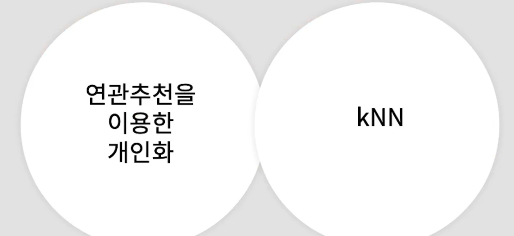

# Personalized Recommendation

## Initialize Database & Libraries

In [ ]:
%reload_ext sql
%run lib.py

%sql postgresql+psycopg2://postgres:@127.0.0.1:5432/fcrec

## Set Test User and Check History

check logs of a user [++MXKfwkOw4VFn9HkVCRrw==]

In [ ]:
query = f'''
    select a.session_id, a.event_timestamp, a.user_no, b.*
    from cmc_event a join cmc_product b on b.item_no = a.item_no 
    where user_no = '++MXKfwkOw4VFn9HkVCRrw=='
        and event_timestamp between '2021-07-18' and '2021-07-25'
    order by event_timestamp desc
    limit 20;
    '''

result = executeQuery(query)
result

displayItemDetailInRows(result)

image,session_id,event_timestamp,item_no,item_name,category1_name,category2_name,category3_name,price,brand_name
,bca82e41ee7b0833588399b1fcd177c7,2021-07-23 16:32:14.841136,1+pqWFazLqQAJSBMdZ8pMw==,"[이사배,유아 착용] [silver925] blossom bracelet",잡화,주얼리,팔찌,60000.0,roaju
,bca82e41ee7b0833588399b1fcd177c7,2021-07-23 16:24:50.823015,cvzxtllmGTglR+SVGjRiKw==,[unisex]TWEED BLACK BUCKET HAT,잡화,모자,버킷햇,44000.0,sleepyslip
,bca82e41ee7b0833588399b1fcd177c7,2021-07-23 16:24:47.413003,cvzxtllmGTglR+SVGjRiKw==,[unisex]TWEED BLACK BUCKET HAT,잡화,모자,버킷햇,44000.0,sleepyslip
,bca82e41ee7b0833588399b1fcd177c7,2021-07-23 16:23:15.208033,OH7asqBmkHaSxKb8mw/WNg==,[unisex]GLENCHECH NAVY BUCKET HAT,잡화,모자,버킷햇,56000.0,sleepyslip
,bca82e41ee7b0833588399b1fcd177c7,2021-07-23 16:21:36.694017,VYGimxgPANog/nRMZ0O1mw==,[unisex]STITCH WOOL BLACK BUCKET HAT,잡화,모자,버킷햇,56000.0,sleepyslip
,a02ffd91ece5e7efeb46db8f10a74059,2021-07-20 06:59:53.616130,RBm42X6EPR25ERPNqEj5mA==,vienna layered anklet,잡화,주얼리,발찌,56000.0,Hei
,a02ffd91ece5e7efeb46db8f10a74059,2021-07-20 06:59:01.905118,2AmJgXyJXsjaqr27jy08UA==,[태민 착용] ball chain layered bracelet,잡화,주얼리,팔찌,49000.0,Hei
,a02ffd91ece5e7efeb46db8f10a74059,2021-07-20 06:57:33.551098,QJ/0MTR30pqYMFSPRU/r9Q==,"[비비, 최수영, 조이현 착용] unbalance chain earring",잡화,주얼리,귀걸이,52000.0,Hei
,a02ffd91ece5e7efeb46db8f10a74059,2021-07-20 06:56:59.769086,b/pABsFJ4F4CuZJX6G3/wQ==,"[트와이스 미나, 오마이걸 아린&승희, 형원 착용] coral set ring",잡화,주얼리,반지,21000.0,Hei
,a02ffd91ece5e7efeb46db8f10a74059,2021-07-20 06:55:27.326070,UqyVlzDDSbJLTH6fHqa1aQ==,"[오마이걸 유아&지호, 써니, SF9찬희, 우아 나나 착용] rainbow daisy bracelet",잡화,주얼리,팔찌,39000.0,Hei


# Recommend based on Item Similarity

In [ ]:
query1 = f'''
	with rec as (
		select b.b_item_no, sum(a.time_weight * b.sim) score
		from (
			select item_no, pow(0.9, (date_part('day', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp) * 24 + date_part('hour', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp))/12) time_weight 
			from cmc_event 
			where user_no = '++MXKfwkOw4VFn9HkVCRrw=='
				and event_timestamp between '2021-07-18' and '2021-07-25'
			order by event_timestamp desc
			limit 10
			) a 
			join 
			(
			select a_item_no, b_item_no, sim
			from (
				select a_item_no, b_item_no, sim, row_number() over (partition by a_item_no order by sim desc) rank
				from (
					select a.item_no a_item_no, b.item_no b_item_no, sum(a.w * b.w) sim
					from cmc_session_product_click_w a 
						join cmc_session_product_click_w b on a.session_id = b.session_id and a.item_no != b.item_no 
					where a.item_no in (
						select item_no
						from cmc_event 
						where user_no = '++MXKfwkOw4VFn9HkVCRrw=='
							and event_timestamp between '2021-07-18' and '2021-07-25'
						order by event_timestamp desc
						limit 10 )
					group by a.item_no, b.item_no ) t
				) t
			where rank <= 20
			) as b on a.item_no = b.a_item_no
		group by b.b_item_no
		order by score desc
		limit 20 )
	select a.score, b.*
	from rec a join cmc_product b on a.b_item_no = b.item_no;
	'''

result1 = executeQuery(query1)

In [ ]:
print('User Hisotry')
displayItemInRows(result)

print('Recommended Items')
displayItemInRows(result1)

User Hisotry


Recommended Items


# User-based Personalization (kNN)

In [ ]:
query2 = '''
    with rec as (
        select b.item_no, sum(a.sim * b.w) score
        from (
            select b.user_no, sum(a.w * b.w) sim
            from cmc_user_product_click_w a join cmc_user_product_click_w b on a.item_no = b.item_no and a.user_no != b.user_no 
            where a.user_no = '++MXKfwkOw4VFn9HkVCRrw=='
            group by b.user_no
            order by sim desc
            limit 20 ) a
            join cmc_user_product_click_w b on b.user_no = a.user_no
        group by b.item_no
        order by score desc
        limit 20)
    select a.score, b.*
    from rec a join cmc_product b on a.item_no = b.item_no
    '''
result2 = executeQuery(query2)

In [ ]:
print('User Hisotry')
displayItemInRows(result)

print('Item-based Recommended Items')
displayItemInRows(result1)

print('User-based Recommended Items')
displayItemInRows(result2)

User Hisotry


Item-based Recommended Items


User-based Recommended Items


In [ ]:
query3 = '''
    with rec as (
        select b.item_no, sum(sim * event_weight * time_weight) score
        from (
            select b.user_no, sum(a.w * b.w) sim
            from cmc_user_product_click_w a join cmc_user_product_click_w b on a.item_no = b.item_no and a.user_no != b.user_no 
            where a.user_no = '++MXKfwkOw4VFn9HkVCRrw=='
            group by b.user_no
            order by sim desc
            limit 20 ) a
            join (
            select user_no, item_no,
                case 
                    when event_name = 'purchase_success' then 3
                    when event_name = 'add_to_cart' then 2
                    when event_name = 'like_item' then 1
                end event_weight,
                pow(0.9, (date_part('day', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp) * 24 + date_part('hour', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp))/12)  time_weight
            from  cmc_event
            where event_timestamp between '2021-07-18' and '2021-07-25'
                and event_name in ('purchase_success', 'like_item', 'add_to_cart')
                ) b on b.user_no = a.user_no 
        group by b.item_no
        order by score desc 
        limit 20)
    select a.score, b.*
    from rec a join cmc_product b on a.item_no = b.item_no
    '''

result3 = executeQuery(query3)

print('User Hisotry')
displayItemInRows(result)

print('Item-based Recommended Items')
displayItemInRows(result1)

print('User-based Recommended Items')
displayItemInRows(result2)

displayItemInRows(result3)

User Hisotry


Item-based Recommended Items


User-based Recommended Items
